In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 4]

## Preparation

#### Import data

In [2]:
df = pd.read_csv('data/to_model.csv', index_col = 0)

In [3]:
df.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,goout,famrel,guardian,Mjob,Fjob,sex,Pstatus,romantic
0,18,4,4,0,2,2,1,1,6,6,4,4,mother,at_home,teacher,F,A,no
1,17,1,1,0,1,2,1,1,4,6,3,5,father,at_home,other,F,T,no
2,15,1,1,3,1,2,2,3,10,10,2,4,mother,at_home,other,F,T,no
3,15,4,2,0,1,3,1,1,2,15,2,3,mother,health,services,F,T,yes
4,16,3,3,0,1,2,1,2,4,10,2,4,father,other,other,F,T,no


#### Dummies encoding

In [4]:
df2 = pd.get_dummies(df, drop_first = True)

#### Train/test split

In [5]:
from sklearn.model_selection import train_test_split
import random
X_train, X_test, y_train, y_test = train_test_split(df2, df2.Final_grade, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape)

(316, 25) (79, 25)


In [6]:
X_train.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,...,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,sex_M,Pstatus_T,romantic_yes
266,17,3,1,0,1,2,3,4,2,10,...,0,1,0,0,1,0,0,1,1,1
352,18,1,3,1,1,1,2,3,7,8,...,0,0,0,0,0,1,0,1,1,1
97,16,2,1,0,1,2,1,1,2,10,...,1,0,0,0,1,0,0,0,1,1
167,16,4,2,0,1,2,1,1,0,16,...,0,0,0,0,0,1,0,0,1,1
280,17,4,1,0,2,1,2,4,30,8,...,0,1,0,0,1,0,0,1,0,1


#### Mutual info

First running mutual information to get intuition

In [7]:
from sklearn import feature_selection
mutual_info = feature_selection.mutual_info_classif(X_train, y_train, discrete_features=True)

In [8]:
pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False)

,minfo,col
9,2.593763,Final_grade
8,0.633463,absences
3,0.163247,failures
0,0.137014,age
1,0.133067,Medu
7,0.127030,Walc
10,0.124776,goout
2,0.100426,Fedu
5,0.097476,studytime
6,0.096018,Dalc


In [9]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

## Modeling

### Linear regression

#### First model - LR with best variable according to mutual info

In [10]:
cols_to_fit = [
 'absences',
]

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.121
Date:                Tue, 02 Jun 2020   Prob (F-statistic):              0.291
Time:                        11:02:25   Log-Likelihood:                -936.00
No. Observations:                 316   AIC:                             1876.
Df Residuals:                     314   BIC:                             1884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1411      0.338     30.033      0.000       9.477      10.805
absences       0.0396      0.037      1.059      0.291      -0.034       0.113
==============================================================================
Omnibus:                       21.388   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.232
Skew:                          -0.677   Prob(JB):                     5.47e-06
Kurtosis:                       3.072   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance with R2 = 0.004 is mediocre. Absences is not significant. Probably these is nonlinear?

#### LR with all variables

In [11]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3.926
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.10e-08
Time:                        11:02:25   Log-Likelihood:                -892.25
No. Observations:                 316   AIC:                             1835.
Df Residuals:                     291   BIC:                             1928.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.6387      4.147      3.530      0.000       6.478      22.800
absences            0.0811      0.037      2.211      0.028       0.009       0.153
failures           -2.0369      0.373     -5.461      0.000      -2.771      -1.303
age                -0.1444      0.219     -0.659      0.510      -0.576       0.287
Medu                0.3997      0.359      1.114      0.266      -0.306       1.106
Walc                0.2342      0.281      0.833      0.406      -0.319       0.788
goout              -0.6630      0.250     -2.651      0.008      -1.155      -0.171
Fedu               -0.1397      0.308     -0.453      0.651      -0.746       0.467
studytime           0.4461      0.331      1.349      0.179      -0.205       1.097
Dalc               -0.0487      0.385     -0.127      0.899      -0.807       0.709
famrel              0.2891      0.293      0.988      0.324      -0.287       0.865
traveltime         -0.6728      0.374     -1.797      0.073      -1.410       0.064
romantic_yes       -0.8878      0.535     -1.660      0.098      -1.941       0.165
Mjob_services       0.6664      0.887      0.752      0.453      -1.079       2.412
Fjob_teacher        0.2636      1.458      0.181      0.857      -2.606       3.133
Fjob_services      -1.0848      1.189     -0.912      0.362      -3.426       1.256
sex_M               1.2146      0.541      2.245      0.026       0.150       2.279
Fjob_other         -1.1553      1.171     -0.986      0.325      -3.460       1.150
Mjob_health         1.3964      1.271      1.099      0.273      -1.105       3.898
Mjob_other         -0.6897      0.809     -0.853      0.395      -2.282       0.903
guardian_other     -0.0431      1.101     -0.039      0.969      -2.210       2.124
Mjob_teacher       -0.7496      1.130     -0.663      0.508      -2.974       1.474
Fjob_health        -0.3151      1.690     -0.186      0.852      -3.642       3.011
Pstatus_T          -0.7623      0.842     -0.905      0.366      -2.420       0.896
guardian_mother    -0.6140      0.643     -0.955      0.340      -1.879       0.651
==============================================================================
Omnibus:                       21.250   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.555
Skew:                          -0.647   Prob(JB):                     7.68e-06
Kurtosis:                       3.342   Cond. No.                         343.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance got better, with R2 = 0.245.

#### LR with one variable at the time

Now fitting a model with only one variable at a time.

In [12]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [13]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.127893
3,Medu,0.047465
6,Fedu,0.028789
5,goout,0.025503
2,age,0.023633


Failures is the best one - 3 times as good as the second one. 

Now trying the same thing as above with testing one variable at a time, but using first squared variables, and then square rooted (an attempt to capture nonlinearity)

In [14]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [15]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.105651
3,Medu,0.054122
6,Fedu,0.029472
5,goout,0.028201
2,age,0.023112


Nothing changed here - top 5 predictors are still the same. Now trying square roots.

In [16]:
r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 1/2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [17]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.126626
3,Medu,0.035716
6,Fedu,0.024323
2,age,0.023833
0,absences,0.023581


This is almost the same as previously - except that absences entered the top 5 and goout dropped. absences was indicated as important predictor by mutual info

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]


mod = LinearRegression()
mod.fit(X_train[cols_to_fit], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(y_train, mod.predict(X_train[cols_to_fit]))

0.24458652935703795

In [22]:
r2_score(y_test, mod.predict(X_test[cols_to_fit]))

0.06602771492040727

Performance on test set is very poor

In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [24]:
mean_squared_error(y_train, mod.predict(X_train[cols_to_fit]))

16.59793696985791

In [25]:
mean_squared_error(y_test, mod.predict(X_test[cols_to_fit]))

15.636440983628642

In [26]:
mean_absolute_error(y_train,mod.predict(X_train[cols_to_fit]))

3.177234569559943

In [27]:
mean_absolute_error(y_test,mod.predict(X_test[cols_to_fit]))

3.0567951963764366

#### Recursive feature elimination from LR

In [28]:
from sklearn.feature_selection import RFE, RFECV

In [29]:
rfe = RFE(mod, n_features_to_select = 1)
rfe.fit(X_train[cols_to_fit], y_train)
rfe.ranking_
pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank').head(7)

,col,rank
1,failures,1
17,Mjob_health,2
12,Mjob_services,3
16,Fjob_other,4
14,Fjob_services,5
15,sex_M,6
22,Pstatus_T,7


Failures is again ranked as the best, while importance of student's parents is visible now.

Now adding prediction on test set for gradually increasing number of parameters

In [30]:
rankings = pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank')

r2_vals = []
rmse_vals = []
mae_vals = []

for i in range(1, len(rankings)):
#     pass
    features = list(rankings.iloc[:i,0])
#     print(f'fitting for {i}')
    mod = LinearRegression()
    mod.fit(X_train[features], y_train)
    
    # R2
    r2_train = r2_score(y_train, mod.predict(X_train[features]))
    r2_test = r2_score(y_test, mod.predict(X_test[features]))
    r2_vals.append((r2_train, r2_test))
    
    # RMSE
    rmse_train = mean_squared_error(y_train, mod.predict(X_train[features]))
    rmse_test = mean_squared_error(y_test, mod.predict(X_test[features]))
    rmse_vals.append((rmse_train, rmse_test))

    # MAE
    mae_train = mean_absolute_error(y_train,mod.predict(X_train[features]))
    mae_test = mean_absolute_error(y_test,mod.predict(X_test[features]))
    mae_vals.append((mae_train,mae_test))
    # print((rmse_train, rmse_test,mae_test))
    
    
#     print(i)

In [31]:
rfe_r2_df = pd.DataFrame(r2_vals, columns = ['train', 'test']).reset_index()
rfe_rmse_df = pd.DataFrame(rmse_vals, columns = ['train', 'test']).reset_index()
rfe_mae_df = pd.DataFrame(mae_vals,columns=['train','test']).reset_index()

#### Plot - Comparison of R^2 for train and validation sets depending on number of features

In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'MAE')

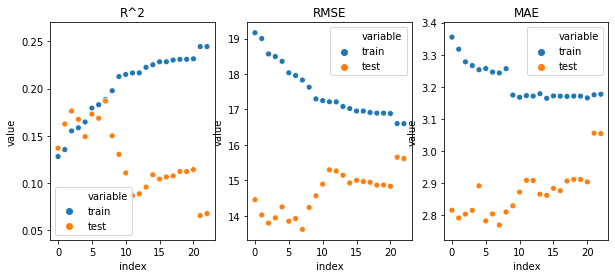

In [33]:
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_r2_df, id_vars = 'index')).set_title('R^2')

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_rmse_df, id_vars = 'index')).set_title('RMSE')

plt.subplot(1, 3, 3)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_mae_df, id_vars = 'index')).set_title('MAE')

So, about 8 first features gives similar outcome for train and test set, anythig more than than ruins validation score. An interesting observation is RMSE on train set is higher than test. 

Fitting linear model with these variables

In [34]:
cols_to_fit = list(rankings.iloc[:8,0])

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.918
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           5.38e-11
Time:                        11:02:26   Log-Likelihood:                -903.55
No. Observations:                 316   AIC:                             1825.
Df Residuals:                     307   BIC:                             1859.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.2219      1.005     12.155      0.000      10.243      14.200
failures         -2.2667      0.329     -6.889      0.000      -2.914      -1.619
Mjob_health       2.1717      0.928      2.341      0.020       0.347       3.997
Mjob_services     1.3811      0.572      2.414      0.016       0.255       2.507
Fjob_other       -1.2690      0.678     -1.870      0.062      -2.604       0.066
Fjob_services    -1.0669      0.763     -1.398      0.163      -2.568       0.434
sex_M             1.0872      0.487      2.233      0.026       0.129       2.045
Pstatus_T        -0.9779      0.819     -1.193      0.234      -2.590       0.635
romantic_yes     -0.7652      0.520     -1.472      0.142      -1.788       0.258
==============================================================================
Omnibus:                       27.067   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.423
Skew:                          -0.739   Prob(JB):                     1.50e-07
Kurtosis:                       3.449   Cond. No.                         8.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From statistical inference point of view, Father job and romantic variables should be ommited as they are statistically insignificant

### Feature generation/selection

#### Benchmark model

Best 8 features

In [35]:
cols_to_fit = list(rankings.iloc[:8,0])

mod = LinearRegression()
res = mod.fit(add_constant(X_train[cols_to_fit]), X_train['Final_grade'])

rmse_train = mean_squared_error(y_train, mod.predict(add_constant(X_train[cols_to_fit])))
rmse_test = mean_squared_error(y_test, mod.predict(add_constant(X_test[cols_to_fit])))
print("train:", rmse_train, "test: ", rmse_test)

train: 17.828843800126492 test:  13.615130070573631


In [36]:
cols_to_fit

['failures',
 'Mjob_health',
 'Mjob_services',
 'Fjob_other',
 'Fjob_services',
 'sex_M',
 'Pstatus_T',
 'romantic_yes']

There is no absences variable. From the plot it looks promising, there is some non_linearity that LR can't account for.

Text(0.5, 1.0, 'absences')

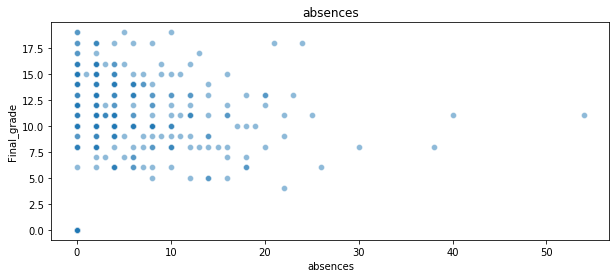

In [37]:
sns.scatterplot(x = 'absences', y = 'Final_grade', data = X_train, alpha = 0.5).set_title('absences')

#### Absences - threshold

In [38]:
cols_to_fit = list(rankings.iloc[:8,0])# + ['absences']

mod = LinearRegression()
res = mod.fit(add_constant(X_train[cols_to_fit]), X_train['Final_grade'])

rmse_train = mean_squared_error(y_train, mod.predict(add_constant(X_train[cols_to_fit])))
rmse_test = mean_squared_error(y_test, mod.predict(add_constant(X_test[cols_to_fit])))
print("train:", rmse_train, "test: ", rmse_test)

train: 17.828843800126492 test:  13.615130070573631


In [39]:
scores = []
for threshold in range(10, 50):
#     print('Threshold: ', threshold)
    abs_temp = X_train.copy()
    abs_temp['thr'] = abs_temp.absences>threshold

    abs_temp_test = X_test.copy()
    abs_temp_test['thr'] = abs_temp_test.absences>threshold

    cols_to_fit = list(rankings.iloc[:8,0]) + ['thr']

    mod = LinearRegression()
    res = mod.fit(add_constant(abs_temp[cols_to_fit]), X_train['Final_grade'])

    rmse_train = mean_squared_error(y_train, mod.predict(add_constant(abs_temp[cols_to_fit])))
    rmse_test = mean_squared_error(y_test, mod.predict(add_constant(abs_temp_test[cols_to_fit])))
    scores.append((threshold, rmse_train, rmse_test))
#     print("train:", rmse_train, "test: ", rmse_test)

Text(0.5, 1.0, 'RMSE')

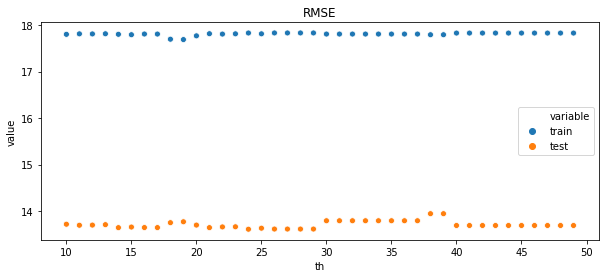

In [40]:
a = pd.DataFrame(scores, columns = ['th', 'train', 'test'])
sns.scatterplot(x = 'th', y= 'value', hue = 'variable', data = pd.melt(a, id_vars = 'th')).set_title('RMSE')

#### Absences - roots

In [41]:
scores = []
for threshold in range(10, 11):
#     print('Threshold: ', threshold)
    abs_temp = X_train.copy()
    abs_temp['thr'] = abs_temp.absences**(1/20)

    abs_temp_test = X_test.copy()
    abs_temp_test['thr'] = abs_temp_test.absences**(1/20)

    cols_to_fit = list(rankings.iloc[:8,0]) + ['thr']

    mod = LinearRegression()
    res = mod.fit(add_constant(abs_temp[cols_to_fit]), X_train['Final_grade'])

    rmse_train = mean_squared_error(y_train, mod.predict(add_constant(abs_temp[cols_to_fit])))
    rmse_test = mean_squared_error(y_test, mod.predict(add_constant(abs_temp_test[cols_to_fit])))
    scores.append((threshold, rmse_train, rmse_test))
    print("train:", rmse_train, "test: ", rmse_test)

train: 16.387996747776533 test:  13.347514671257512


Text(0.5, 1.0, 'absences')

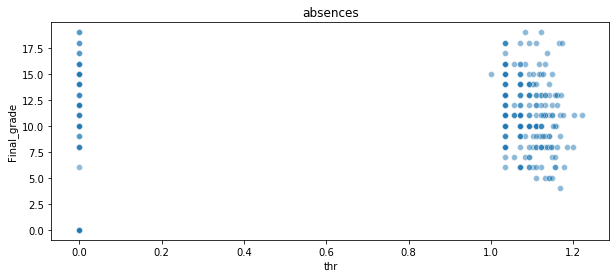

In [42]:
sns.scatterplot(x = 'thr', y = 'Final_grade', data = abs_temp, alpha = 0.5).set_title('absences')

### Using Hurdle regression

Implementation taken from https://geoffruddock.com/building-a-hurdle-regression-estimator-in-scikit-learn/ - copied to hurdle.py file

In [43]:
from hurdle import HurdleRegression
cols_to_fit = list(rankings.iloc[:1,0])

mod = HurdleRegression()
res = mod.fit(add_constant(X_train[cols_to_fit]), X_train['Final_grade'])

rmse_train = mean_squared_error(y_train, mod.predict(add_constant(X_train[cols_to_fit])))
rmse_test = mean_squared_error(y_test, mod.predict(add_constant(X_test[cols_to_fit])))
print("train:", rmse_train, "test: ", rmse_test)

train: 20.771693948882398 test:  15.348590737149955


In [44]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

rankings = pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank')

r2_vals = []
rmse_vals = []
mae_vals = []

for i in range(2, len(rankings)):
#     pass
    features = list(rankings.iloc[:i,0])
#     print(f'fitting for {i}')
    mod = HurdleRegression()
    mod.fit(X_train[features], y_train)
    
    # R2
    r2_train = r2_score(y_train, mod.predict(X_train[features]))
    r2_test = r2_score(y_test, mod.predict(X_test[features]))
    r2_vals.append((r2_train, r2_test))
    
    # RMSE
    rmse_train = mean_squared_error(y_train, mod.predict(X_train[features]))
    rmse_test = mean_squared_error(y_test, mod.predict(X_test[features]))
    rmse_vals.append((rmse_train, rmse_test))

    # MAE
    mae_train = mean_absolute_error(y_train,mod.predict(X_train[features]))
    mae_test = mean_absolute_error(y_test,mod.predict(X_test[features]))
    mae_vals.append((mae_train,mae_test))
    # print((rmse_train, rmse_test,mae_test))
    
    
#     print(i)

In [45]:
rfe_r2_df = pd.DataFrame(r2_vals, columns = ['train', 'test']).reset_index()
rfe_rmse_df = pd.DataFrame(rmse_vals, columns = ['train', 'test']).reset_index()
rfe_mae_df = pd.DataFrame(mae_vals,columns=['train','test']).reset_index()

Comparison of R^2 for train and validation sets depending on number of features

Text(0.5, 1.0, 'MAE')

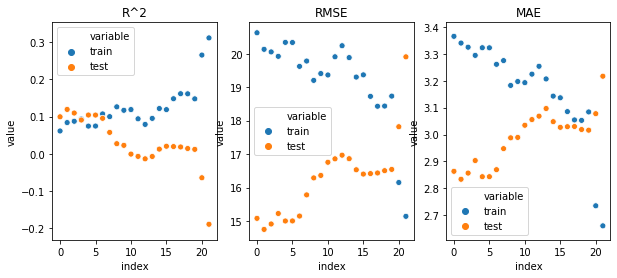

In [46]:
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_r2_df, id_vars = 'index')).set_title('R^2')

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_rmse_df, id_vars = 'index')).set_title('RMSE')

plt.subplot(1, 3, 3)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_mae_df, id_vars = 'index')).set_title('MAE')

### KNN

In [57]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
from sklearn  import metrics
from sklearn import neighbors

In [59]:
knn = KNeighborsRegressor()
mod = knn.fit(X_train[cols_to_fit],y_train)
print("Train Score", knn.score(X_train[cols_to_fit],y_train))
print("Test Score",knn.score(X_test[cols_to_fit],y_test))

k_fold  = KFold(n_splits=10, shuffle = True ,random_state=random.randint(0,10000))
results = cross_val_score(knn, X_train[cols_to_fit], y_train, cv=k_fold)
print(results)

Train Score 0.4083664116570609
Test Score 0.11269222670979862
[ 0.26347335  0.23778723  0.01787426  0.1133741  -0.11002634  0.30556759
  0.19731573 -0.06220805 -0.12703103 -0.34194631]


In [60]:
featuresCopy = cols_to_fit.copy()
kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))
selectdFeat = []
for k in range(10):
    results = []
    for oneFeat in featuresCopy:
        tempFeatures = selectdFeat + [oneFeat]
        n_neighbors = 5
        clf = neighbors.KNeighborsRegressor(n_neighbors, n_jobs=-1, p=2)
        aucs = []
        accs = []
        for train, test in kf.split(X_train.index.values):
            clf.fit(X_train.iloc[train][tempFeatures].values, X_train.iloc[train]["Final_grade"].values)
            pred = clf.predict(X_train.iloc[test][tempFeatures].values)
            predsTrain = clf.predict(X_train.iloc[train][tempFeatures].values)
            aucs.append(metrics.r2_score(X_train.iloc[test]["Final_grade"].values,pred))
            accs.append(metrics.mean_squared_error(X_train.iloc[test]["Final_grade"].values,pred))
        print(tempFeatures)
        print(oneFeat, np.mean(aucs))
        results.append((np.mean(aucs), oneFeat))
    selectdFeat.append(sorted(results, key=lambda x: x[0], reverse=True)[0][1])
    featuresCopy.remove(sorted(results, key=lambda x: x[0], reverse=True)[0][1])

['absences']
absences -0.03772587985710383
['failures']
failures 0.03875282346387423
['age']
age -0.14813785444727884
['Medu']
Medu -0.08065773869552331
['Walc']
Walc -0.08321347059244691
['goout']
goout -0.1897044231671245
['Fedu']
Fedu -0.22290988134176776
['studytime']
studytime -0.22317518649275409
['Dalc']
Dalc -0.16991933687480199
['famrel']
famrel -0.28327575120974763
['traveltime']
traveltime -0.26664354138267743
['romantic_yes']
romantic_yes -0.29004799897930567
['Mjob_services']
Mjob_services -0.16396010814138956
['Fjob_teacher']
Fjob_teacher -0.09209501846875337
['Fjob_services']
Fjob_services -0.18713304603237496
['sex_M']
sex_M -0.16064163298322284
['Fjob_other']
Fjob_other -0.2081426079719389
['Mjob_health']
Mjob_health -0.051700917953721316
['Mjob_other']
Mjob_other -0.04584191972694836
['guardian_other']
guardian_other -0.0525592645712343
['Mjob_teacher']
Mjob_teacher -0.16171416630502286
['Fjob_health']
Fjob_health -0.18239690674471495
['Pstatus_T']
Pstatus_T -0.142969

Feature: 0, Score: 8.48132
Feature: 1, Score: 1.56499
Feature: 2, Score: 1.27167
Feature: 3, Score: 1.04213
Feature: 4, Score: -0.40228
Feature: 5, Score: -0.35600
Feature: 6, Score: 0.85116
Feature: 7, Score: 0.11491
Feature: 8, Score: 0.02603
Feature: 9, Score: -0.00529
Feature: 10, Score: -0.12291
Feature: 11, Score: -0.38215
Feature: 12, Score: -0.14481
Feature: 13, Score: -0.12554
Feature: 14, Score: 0.01570
Feature: 15, Score: -0.00846
Feature: 16, Score: 0.48901
Feature: 17, Score: 0.10081
Feature: 18, Score: -0.03927
Feature: 19, Score: -0.02605
Feature: 20, Score: -0.21861
Feature: 21, Score: -0.02122
Feature: 22, Score: -0.12516
Feature: 23, Score: 0.19276


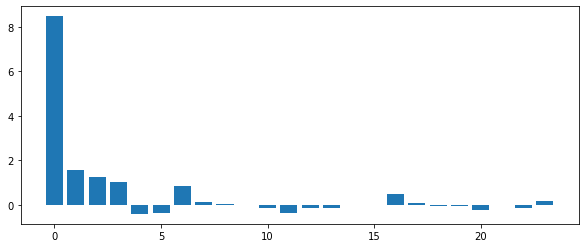

In [62]:
results = permutation_importance(knn, X_train[cols_to_fit], y_train,scoring='neg_mean_squared_error')
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
#plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


(???) Feature 8 and 9 has more importances to other features, which are walc and absence .

In [63]:
knn_models = {}
for i in range(1, 50):
    knn_models[str(i)] = KNeighborsRegressor(n_neighbors=i);
    knn_models[str(i)].fit(X_train[cols_to_fit],y_train);
    score = knn_models[str(i)].score(X_test[cols_to_fit],y_test)
    print("Validation score for n_neighbors = " + str(i) + " is " + str(score))

Validation score for n_neighbors = 1 is -1.1132496219589223
Validation score for n_neighbors = 2 is -0.215780104511609
Validation score for n_neighbors = 3 is 0.05296509686571538
Validation score for n_neighbors = 4 is 0.03325445514231595
Validation score for n_neighbors = 5 is 0.11269222670979862
Validation score for n_neighbors = 6 is 0.07883990837688004
Validation score for n_neighbors = 7 is 0.07754891095653105
Validation score for n_neighbors = 8 is 0.0984074720536724
Validation score for n_neighbors = 9 is 0.0898824415723013
Validation score for n_neighbors = 10 is 0.14698811324005157
Validation score for n_neighbors = 11 is 0.12300718685393118
Validation score for n_neighbors = 12 is 0.11305262587013275
Validation score for n_neighbors = 13 is 0.1110218667499071
Validation score for n_neighbors = 14 is 0.08259845963154178
Validation score for n_neighbors = 15 is 0.0734666845318992
Validation score for n_neighbors = 16 is 0.05561204072794457
Validation score for n_neighbors = 17 

After 5 neighbors the score decreases slowly.

In [65]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

grid_params = {
    'n_neighbors': [3,5,7,11],
    'metric': ['euclidean','manhattan']
}

gs =GridSearchCV(knn,grid_params,verbose=1,cv=5,n_jobs=-1)

gs_results = gs.fit(X_train[cols_to_fit],y_train)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [66]:
print('Best score',gs_results.best_score_)
print(gs_results.best_params_)
print(gs_results.best_estimator_)

Best score 0.13117049667820793
{'metric': 'euclidean', 'n_neighbors': 11}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='uniform')


### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.1,20,80)

scores = []
scores_rmse = []
scores_mae = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []

    mae_train = []
    mae_test = []
    
    for train, test in kf.split(X_train.index.values):
        
        reg = Ridge(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))

        mae_test.append(mean_absolute_error(X_train.iloc[test].Final_grade, preds))
        mae_train.append(mean_absolute_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)   
    
    b = (alpha, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)  

    c = (alpha,np.mean(mae_test),np.mean(mae_train)) 
    scores_mae.append(c)

In [ ]:
r2_scores_ridge = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])
rmse_scores_ridge = pd.DataFrame(scores_rmse, columns = ['alpha', 'test', 'train'])
mae_scores_ridge = pd.DataFrame(scores_mae,columns = ['alpha','test','train'])

In [ ]:
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_ridge, id_vars = 'alpha')).set_title('R^2')
plt.subplot(1, 3, 2)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_ridge, id_vars = 'alpha')).set_title('MSE')
plt.subplot(1, 3, 3)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(mae_scores_ridge, id_vars = 'alpha')).set_title('MAE')

### Lasso regression

Now I'm trying to fit Lasso regression - as a mean of feature selection

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.01, 0.5, 80)

scores = []
scores_rmse = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    
    for train, test in kf.split(X_train.index.values):
        
        reg = Lasso(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)   
    
    b = (alpha, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)   
#     print(a)


In [ ]:
r2_scores_lasso = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])
rmse_scores_lasso = pd.DataFrame(scores_rmse, columns = ['alpha', 'test', 'train'])

In [ ]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_lasso, id_vars = 'alpha')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_lasso, id_vars = 'alpha')).set_title('RMSE')

Alpha around 0.1-0.2 seems correct. The score is dropping very slowly, so to obtain parsimonious model I have used alpha = 0.2

In [ ]:
mod = Lasso(alpha = 0.2)
mod.fit(X_train[cols_to_fit], y_train)

In [ ]:
lasso_coefs = pd.DataFrame({'col': cols_to_fit, 'coef':mod.coef_}).query('coef != 0')
lasso_coefs

About 10 features are still present in the model.

In [ ]:
r2_score(y_train, mod.predict(X_train[cols_to_fit]))

In [ ]:
r2_score(y_test, mod.predict(X_test[cols_to_fit]))

In [ ]:
mean_squared_error(y_train, mod.predict(X_train[cols_to_fit]))

In [ ]:
mean_squared_error(y_test, mod.predict(X_test[cols_to_fit]))

R2 score for train dataset is very similar to the one obtained by taking best 8 features. However performance on the test set varies significantly - ~0.18 vs 0.1

### SVM modeling

In [ ]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]


#### SVM with features from mutual infromation

In [ ]:
from sklearn.svm import SVR

As SVM is a nonlinear model, let's use the 10 best variables obtained from mutual information

In [ ]:
list(pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False).head(11).col)

cols_to_fit = [
    'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel'
]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 30, 300)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    
#     print(a)


In [ ]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

In [ ]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')

Value of c around 12 seems ok by criterion of R2, however using RMSE best value is ~25-30 - then performance on the CV test set is the best from models tried so far

#### SVM with features from linear regression

Now trying the model on the best features obtained from linear regression

In [ ]:
cols_to_fit = ['failures',
 'Mjob_health',
 'Mjob_services',
 'Fjob_other',
 'Fjob_services',
 'sex_M',
 'Pstatus_T',
 'romantic_yes']

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 20, 200)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    
#     print(a)


In [ ]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

In [ ]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')

Now it's completely different picture - c around 0.8 seems correct. However model's performance has dropped dramatically - it seems that the desicion to take best mutual info scores rather than LR scores is correct. Also, way poorer overfitting.

In [ ]:
### SVM with more features

In [ ]:
cols_to_fit = list(pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False).iloc[1:].head(16).col)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 60, 30)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    
#     print(a)


In [ ]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

In [ ]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')